# Hands-On: Feature Engineering

This hands-on will cover some techniques in feature engineering in combination with data cleaning and processing.

It covers feature extraction from `datetime` objects, feature transformation from existing variables in the dataset, feature generation and some categorical encoding such as count, label and one-hot encoding.

In [50]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data - CitiBike Trip Histories

CitiBike provides the data of the bike share through this website: https://www.citibikenyc.com/system-data

For this exercise, we'll be using their trip history data which may be found [here](https://s3.amazonaws.com/tripdata/index.html). 

Kindly choose a 2021 month file to download (not the ones with JC as the prefix). You can download data for January or Febuary (20-50MB in file size for slow internet connections) and extract it to your data folder.

**CitiBike trip data includes:**

* Trip Duration (seconds)
* Start Time and Date
* Stop Time and Date
* Start Station Name
* End Station Name
* Station ID
* Station Lat/Long
* Bike ID
* User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
* Gender (Zero=unknown; 1=male; 2=female)
* Year of Birth

In [51]:
# Reading the CSV File and loading it into a pandas dataframe
data = pd.read_csv('data/201712-citibike-tripdata.csv')
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,256,2017-12-01 00:00:00,2017-12-01 00:04:17,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,262,Washington Park,40.691782,-73.973730,18858,Subscriber,1981.0,1
1,325,2017-12-01 00:00:17,2017-12-01 00:05:43,470,W 20 St & 8 Ave,40.743453,-74.000040,490,8 Ave & W 33 St,40.751551,-73.993934,19306,Subscriber,1992.0,1
2,967,2017-12-01 00:00:19,2017-12-01 00:16:26,347,Greenwich St & W Houston St,40.728846,-74.008591,504,1 Ave & E 16 St,40.732219,-73.981656,28250,Subscriber,1992.0,1
3,125,2017-12-01 00:00:20,2017-12-01 00:02:26,3077,Stagg St & Union Ave,40.708771,-73.950953,3454,Leonard St & Maujer St,40.710369,-73.947060,25834,Subscriber,1988.0,1
4,451,2017-12-01 00:00:28,2017-12-01 00:08:00,368,Carmine St & 6 Ave,40.730386,-74.002150,326,E 11 St & 1 Ave,40.729538,-73.984267,14769,Subscriber,1986.0,1


In [52]:
data.dtypes
# if you have dates in your data, it's important to convert them to a datetime object so that we can
# do functions on them to extract information from them.

# NOTE: Always check the datatypes first!
# we need to compare the data that we can see in the data.head() to their datatype so that we can see
# if the expected data type is the same as the data type of the columns.

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                 float64
gender                       int64
dtype: object

In [53]:
data.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                 float64
gender                       int64
dtype: object

### Data Types

These are the types of the dataset. We have a mix of **categorical** (Stations, User Type, Gender), **temporal** (Start Time, Stop Time, Trip Duration) **spatial** and **numerical** data.

## Feature Extraction

From the lecture, we mentioned that we can extract additional information from `datetime` features. Prior to extracting these features, we need to ensure that the `datetime` feature is a `datetime` object in Python so we can easily use the functions available to extract the information.

However, sometimes date and time columns are not automatically converted into a `datetime` object, they are loaded as a `str`. We can be convert the column in two ways:

1. During `pd.read_csv` using the `parse_dates` argument and passing the column name or the index of the column.
2. `pd.to_datetime` method by updating the column.

In [54]:
# Make sure that the date columns have the datetime data type
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

# -> re-assign the entire column after transforming it to a datetime object
# -> NOTE: If the datetime format is not the same for all of the obeservation, then it might not be
# able to detect the parts of the date and time (i.e., where is the year, month, etc.). This is why
# the format should be the same for all. 
# -> You can also specify the string format of the datetime object.

In [55]:
pd.to_datetime?

# -> If it meets a string that does not meet the format/default, then it will raise specific errors
# for specific situations.
# -> we can set the errors to coerce, which can set the invalid parsing to NaT. 
# It will turn it to NULL.
# -> we can set it to ignore it also, which would return the input as it, and we can choose to 
# fix it ourselves.

In [56]:
data.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                        float64
gender                              int64
dtype: object

In [57]:
data.head()

# -> It looks like the time did not change formats because this is actually the correctn format
# that pandas use to represent the datetime object.

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,256,2017-12-01 00:00:00,2017-12-01 00:04:17,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,262,Washington Park,40.691782,-73.973730,18858,Subscriber,1981.0,1
1,325,2017-12-01 00:00:17,2017-12-01 00:05:43,470,W 20 St & 8 Ave,40.743453,-74.000040,490,8 Ave & W 33 St,40.751551,-73.993934,19306,Subscriber,1992.0,1
2,967,2017-12-01 00:00:19,2017-12-01 00:16:26,347,Greenwich St & W Houston St,40.728846,-74.008591,504,1 Ave & E 16 St,40.732219,-73.981656,28250,Subscriber,1992.0,1
3,125,2017-12-01 00:00:20,2017-12-01 00:02:26,3077,Stagg St & Union Ave,40.708771,-73.950953,3454,Leonard St & Maujer St,40.710369,-73.947060,25834,Subscriber,1988.0,1
4,451,2017-12-01 00:00:28,2017-12-01 00:08:00,368,Carmine St & 6 Ave,40.730386,-74.002150,326,E 11 St & 1 Ave,40.729538,-73.984267,14769,Subscriber,1986.0,1


#### Datetime-like properties in `pandas`

Datetimelike properties in a `pandas.Series` can be accessed through `Series.dt`

See the [`pandas` documentation for datetimelike properties](https://pandas.pydata.org/pandas-docs/stable/reference/series.html#datetimelike-properties) to see all possible values.

For this exercise, let's extract the **day of the week** and the **hour of the day** from the starttime. Create a new column for these values.

In [58]:
# -> Each column is seen as a series.
# -> Creating a column to hold the different parts of the date.

# Get the day of week  - start is monday (0)
data['dayofweek'] = data['starttime'].dt.dayofweek

# Get the day of week (name)
data['dayof_week'] = data['starttime'].dt.day_name()

#Get the hour of day
data['hourofday'] = data['starttime'].dt.hour

#Get the year
data['year'] = data['starttime'].dt.year

#Is weekend or not
#List comprehension
data['weekend_weekday_lc'] = ['Weekend' if i >= 5 else 'Weekday' for i in data['dayofweek']]


#Is weekend or not
# Regular for loops
weekend_tag = []
for each in data['dayofweek']:
    if each >= 5:
        weekend_tag.append('Weekend - Regular Loop')
        
    else:
        weekend_tag.append('Weekday - Regular Loop')
        
# -> We create a list that says if a day is a weekday or weekend, then after creating a list
# we will turn it into a column in our DataFrame
    
data['weekend_weekday_rl'] = weekend_tag

In [59]:
# Check if elements were correctly encoded
data[['dayofweek', 'dayof_week','weekend_weekday_lc', 'weekend_weekday_rl']].drop_duplicates().sort_values(by='dayofweek')

# -> We get the unique combinations of these columns to see if they were correctly encoded.

,dayofweek,dayof_week,weekend_weekday_lc,weekend_weekday_rl
123358,0,Monday,Weekday,Weekday - Regular Loop
172989,1,Tuesday,Weekday,Weekday - Regular Loop
214781,2,Wednesday,Weekday,Weekday - Regular Loop
261116,3,Thursday,Weekday,Weekday - Regular Loop
0,4,Friday,Weekday,Weekday - Regular Loop
50708,5,Saturday,Weekend,Weekend - Regular Loop
89631,6,Sunday,Weekend,Weekend - Regular Loop


In [60]:
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,bikeid,usertype,birth year,gender,dayofweek,dayof_week,hourofday,year,weekend_weekday_lc,weekend_weekday_rl
0,256,2017-12-01 00:00:00,2017-12-01 00:04:17,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,262,Washington Park,40.691782,...,18858,Subscriber,1981.0,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop
1,325,2017-12-01 00:00:17,2017-12-01 00:05:43,470,W 20 St & 8 Ave,40.743453,-74.000040,490,8 Ave & W 33 St,40.751551,...,19306,Subscriber,1992.0,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop
2,967,2017-12-01 00:00:19,2017-12-01 00:16:26,347,Greenwich St & W Houston St,40.728846,-74.008591,504,1 Ave & E 16 St,40.732219,...,28250,Subscriber,1992.0,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop
3,125,2017-12-01 00:00:20,2017-12-01 00:02:26,3077,Stagg St & Union Ave,40.708771,-73.950953,3454,Leonard St & Maujer St,40.710369,...,25834,Subscriber,1988.0,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop
4,451,2017-12-01 00:00:28,2017-12-01 00:08:00,368,Carmine St & 6 Ave,40.730386,-74.002150,326,E 11 St & 1 Ave,40.729538,...,14769,Subscriber,1986.0,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop


## Feature Transformation

Currently, the trip duration is in seconds. Depending on the use case or analysis, using seconds might not be easily interpreted by most since we're used to either a trip lasting minutes or hours. 

Let's transform the tripduration in seconds to minutes and see how long the trip actually took.

In [61]:
data['duration_min'] = data['tripduration']/60
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,usertype,birth year,gender,dayofweek,dayof_week,hourofday,year,weekend_weekday_lc,weekend_weekday_rl,duration_min
0,256,2017-12-01 00:00:00,2017-12-01 00:04:17,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,262,Washington Park,40.691782,...,Subscriber,1981.0,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop,4.266667
1,325,2017-12-01 00:00:17,2017-12-01 00:05:43,470,W 20 St & 8 Ave,40.743453,-74.000040,490,8 Ave & W 33 St,40.751551,...,Subscriber,1992.0,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop,5.416667
2,967,2017-12-01 00:00:19,2017-12-01 00:16:26,347,Greenwich St & W Houston St,40.728846,-74.008591,504,1 Ave & E 16 St,40.732219,...,Subscriber,1992.0,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop,16.116667
3,125,2017-12-01 00:00:20,2017-12-01 00:02:26,3077,Stagg St & Union Ave,40.708771,-73.950953,3454,Leonard St & Maujer St,40.710369,...,Subscriber,1988.0,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop,2.083333
4,451,2017-12-01 00:00:28,2017-12-01 00:08:00,368,Carmine St & 6 Ave,40.730386,-74.002150,326,E 11 St & 1 Ave,40.729538,...,Subscriber,1986.0,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop,7.516667


In [62]:
# What if we want to get hour?
data['duration_hour'] = (data['tripduration']/60) / 60

# another solution
data['duration_hour_2'] = data['duration_min']/60
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,gender,dayofweek,dayof_week,hourofday,year,weekend_weekday_lc,weekend_weekday_rl,duration_min,duration_hour,duration_hour_2
0,256,2017-12-01 00:00:00,2017-12-01 00:04:17,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,262,Washington Park,40.691782,...,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop,4.266667,0.071111,0.071111
1,325,2017-12-01 00:00:17,2017-12-01 00:05:43,470,W 20 St & 8 Ave,40.743453,-74.000040,490,8 Ave & W 33 St,40.751551,...,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop,5.416667,0.090278,0.090278
2,967,2017-12-01 00:00:19,2017-12-01 00:16:26,347,Greenwich St & W Houston St,40.728846,-74.008591,504,1 Ave & E 16 St,40.732219,...,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop,16.116667,0.268611,0.268611
3,125,2017-12-01 00:00:20,2017-12-01 00:02:26,3077,Stagg St & Union Ave,40.708771,-73.950953,3454,Leonard St & Maujer St,40.710369,...,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop,2.083333,0.034722,0.034722
4,451,2017-12-01 00:00:28,2017-12-01 00:08:00,368,Carmine St & 6 Ave,40.730386,-74.002150,326,E 11 St & 1 Ave,40.729538,...,1,4,Friday,0,2017,Weekday,Weekday - Regular Loop,7.516667,0.125278,0.125278


In [63]:
# -> We can actually also generate our own duration as we have our own start and end time. But since
# the duration is already given in second, we can use it.

data['duration_computed'] = data['stoptime'] - data['starttime']
data.head()

# -> The format is different as it computes in the number of days, hours, minutes and seconds. So,
# if we do this computation, if we check the datatype, it would actually be a timedelta object.
# -> A timedelta object is just a way for us to get the difference between two dates. It also has
# a way for us to access the attibutes (i.e., days, hours, minutes, seconds).

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,dayofweek,dayof_week,hourofday,year,weekend_weekday_lc,weekend_weekday_rl,duration_min,duration_hour,duration_hour_2,duration_computed
0,256,2017-12-01 00:00:00,2017-12-01 00:04:17,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,262,Washington Park,40.691782,...,4,Friday,0,2017,Weekday,Weekday - Regular Loop,4.266667,0.071111,0.071111,0 days 00:04:17
1,325,2017-12-01 00:00:17,2017-12-01 00:05:43,470,W 20 St & 8 Ave,40.743453,-74.000040,490,8 Ave & W 33 St,40.751551,...,4,Friday,0,2017,Weekday,Weekday - Regular Loop,5.416667,0.090278,0.090278,0 days 00:05:26
2,967,2017-12-01 00:00:19,2017-12-01 00:16:26,347,Greenwich St & W Houston St,40.728846,-74.008591,504,1 Ave & E 16 St,40.732219,...,4,Friday,0,2017,Weekday,Weekday - Regular Loop,16.116667,0.268611,0.268611,0 days 00:16:07
3,125,2017-12-01 00:00:20,2017-12-01 00:02:26,3077,Stagg St & Union Ave,40.708771,-73.950953,3454,Leonard St & Maujer St,40.710369,...,4,Friday,0,2017,Weekday,Weekday - Regular Loop,2.083333,0.034722,0.034722,0 days 00:02:06
4,451,2017-12-01 00:00:28,2017-12-01 00:08:00,368,Carmine St & 6 Ave,40.730386,-74.002150,326,E 11 St & 1 Ave,40.729538,...,4,Friday,0,2017,Weekday,Weekday - Regular Loop,7.516667,0.125278,0.125278,0 days 00:07:32


## Feature Generation

Calculate the age from the birth year.

Observe nulls, the min and max of the calculated birth year. Notice anything problematic?

In [64]:
# -> NOTE: When we have missing data, we should compute how many nulls we have with regards to 
# the entire dataset so that we would know how many are missing.

# Total rows without birth year info 
data['birth year'].isna().sum()

39445

In [65]:
# Percentage of nulls with respect to the entire dataset
(data['birth year'].isna().sum() / len(data['birth year'])) * 100

# -> It's not really a lot since it's only 4% of our data. 

4.432186811421097

In [66]:
# Fill value for nulls is 1700
data['birth year'] = data['birth year'].fillna(1700)

# -> This is basically not a logical information as this person wouldn't be alive anymore.

In [67]:
data['age'] = data['starttime'].dt.year - data['birth year']
data.head()

# What we could do is subtract the year in the starting time with the actual birth year.

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,dayof_week,hourofday,year,weekend_weekday_lc,weekend_weekday_rl,duration_min,duration_hour,duration_hour_2,duration_computed,age
0,256,2017-12-01 00:00:00,2017-12-01 00:04:17,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,262,Washington Park,40.691782,...,Friday,0,2017,Weekday,Weekday - Regular Loop,4.266667,0.071111,0.071111,0 days 00:04:17,36.0
1,325,2017-12-01 00:00:17,2017-12-01 00:05:43,470,W 20 St & 8 Ave,40.743453,-74.000040,490,8 Ave & W 33 St,40.751551,...,Friday,0,2017,Weekday,Weekday - Regular Loop,5.416667,0.090278,0.090278,0 days 00:05:26,25.0
2,967,2017-12-01 00:00:19,2017-12-01 00:16:26,347,Greenwich St & W Houston St,40.728846,-74.008591,504,1 Ave & E 16 St,40.732219,...,Friday,0,2017,Weekday,Weekday - Regular Loop,16.116667,0.268611,0.268611,0 days 00:16:07,25.0
3,125,2017-12-01 00:00:20,2017-12-01 00:02:26,3077,Stagg St & Union Ave,40.708771,-73.950953,3454,Leonard St & Maujer St,40.710369,...,Friday,0,2017,Weekday,Weekday - Regular Loop,2.083333,0.034722,0.034722,0 days 00:02:06,29.0
4,451,2017-12-01 00:00:28,2017-12-01 00:08:00,368,Carmine St & 6 Ave,40.730386,-74.002150,326,E 11 St & 1 Ave,40.729538,...,Friday,0,2017,Weekday,Weekday - Regular Loop,7.516667,0.125278,0.125278,0 days 00:07:32,31.0


In [68]:
data['age'].describe()

# -> We can see the maximum age is 317 years old and the minimum is 16 years old.
# -> The maximum is not useful, and the mean is the as useful right now because we skewed the
# distribution because we actually put in 1700 as the birth year, which made people as 317 years old.

# -> We can analyze those without year separately. It's up to us how we want to analyze it.

count    889967.000000
mean         51.220698
std          58.478108
min          16.000000
25%          29.000000
50%          37.000000
75%          49.000000
max         317.000000
Name: age, dtype: float64

In [69]:
data['age'].value_counts()

317.0    39445
32.0     32892
28.0     32843
27.0     32833
29.0     31705
         ...  
91.0         5
100.0        4
110.0        3
101.0        2
128.0        1
Name: age, Length: 89, dtype: int64

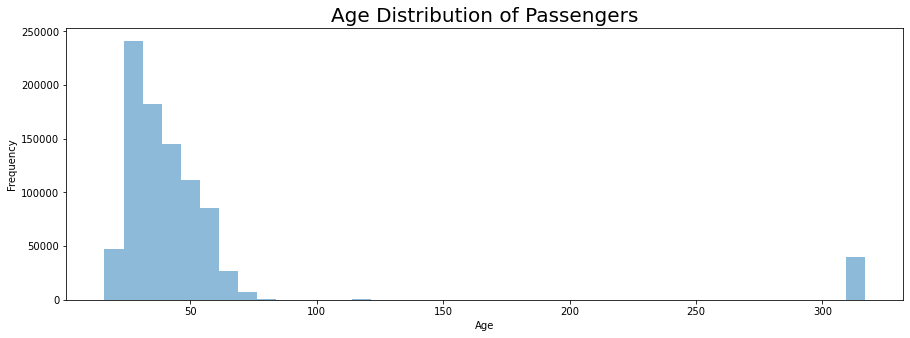

In [71]:
# Plotting the distribution of age
# Look for outliers
plt.figure(figsize=(15,5))
plt.title('Age Distribution of Passengers', fontsize=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.hist(data['age'], bins = 40, alpha = 0.5);


# -> HISTOGRAM -> One quick way to check the distribution of the data.
# -> We can change the number of bins that it would create since it wouldn't really show the 
# distribution as the data has been skewed.
# -> By changing the number of bins, we would be able to see the details of the distribution more.

In [26]:
# What if you want to filter trips
# Lets say we will only consider trips of clients from 0 - 100

data = data[data['age'] <= 100]

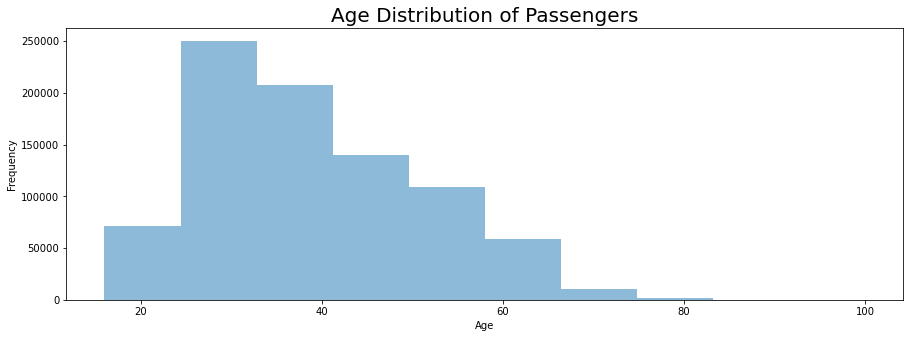

In [27]:
# Plotting the distribution of age after filtering
plt.figure(figsize=(15,5))
plt.title('Age Distribution of Passengers', fontsize=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.hist(data['age'], alpha = 0.5);

#### Distance

Another feature we can generate from the data is distance. Although the provided values are in longitude and latitudes and they're measured in degrees, the distance calculated from these points would also be in degrees (and not meters). 

There's actually a library that specifically handles geospatial data called `geopy` ([Link](https://geopy.readthedocs.io/en/stable/#module-geopy.distance)). For simplicity sake in this tutorial, we use an existing function that calculates the geodesic distance using the Haversine formula given the starting and ending longitude and latitudes: `calculate_distance(lat1, lon1, lat2, lon2)`

Credits to [Wayne Dyck](https://gist.github.com/rochacbruno/2883505) for the function.

In [ ]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the distance provided a pair of longitudes and latitudes
    using the Haversine formula
    
    Returns the distance in kilometers.
    """
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [ ]:
data['distance_km'] = data.apply(lambda x: calculate_distance(x['start station latitude'], x['start station longitude'],
                                        x['end station latitude'], x['end station longitude']), axis=1)

In [ ]:
data.head()

#### Count Encoding

Using the trips raw can be quite useful, but what if we had a different problem we wanted to solve. For example, we want to use the number of trips per origin-destination pair to plan for the initial placement of bikes per station so we can balance out the supply and demand.

We would simply need the number of trips (or bikes used) per origin-destination.

In [ ]:
## Count of rides per OD
od_trips = data.groupby(['start station name', 'end station name'], as_index=False)['bikeid'].count()
od_trips.sort_values(by='bikeid', ascending=False).head()

Alternatively, we can also make this into an origin-destination matrix - which can be useful for visualization and also comparison.

In [ ]:
pd.pivot_table(od_trips, index='start station name', columns='end station name', values='bikeid').fillna(0)

#### Label Encoding and One-Hot Encoding

`scikit-learn` provides encoding functions for preprocessing of data before model training. In this example, we'll use the `usertype` and `gender` categories of the Citibike data for illustration on how to use these encoders.

For further reading on other preprocessing techiniques scikit learn offers, see this [article](https://scikit-learn.org/stable/modules/preprocessing.html).

In [ ]:
users = data[['bikeid', 'usertype', 'gender']]
users.head()

In [ ]:
le_usertype = LabelEncoder()
users['user_encoded'] = le_usertype.fit_transform(users.usertype)

users.head()

In [ ]:
users[['usertype', 'user_encoded']].drop_duplicates()

In [ ]:
gender_ohe = OneHotEncoder()
usertype_ohe = OneHotEncoder()
X_gender = gender_ohe.fit_transform(users.gender.values.reshape(-1,1)).toarray()
X_usertype = usertype_ohe.fit_transform(users.usertype.values.reshape(-1,1)).toarray()

In [ ]:
X_gender

In [ ]:
X_usertype

In [ ]:
users_OH = pd.DataFrame(X_gender, columns = ["gender_"+str(int(i)) for i in range(X_gender.shape[1])])
users_test = pd.concat([users, users_OH], axis=1)

users_OH = pd.DataFrame(X_usertype, columns = ["usertype_"+str(int(i)) for i in range(X_usertype.shape[1])])
users_test = pd.concat([users_test, users_OH], axis=1)

In [ ]:
users_test.head()

#### Label Encoding (using only `pandas`!!!)

`pandas` also has a nifty feature of turning categorical values into numerical labels. 

Steps:
1. Convert the type of the column into category
2. Use `cat.codes` to get the integer label for each value

In [ ]:
users.head()

In [ ]:
users['usertype'] = users['usertype'].astype('category')
users.dtypes

In [ ]:
users['usertype'].head()

In [ ]:
users['usertype_code'] = users['usertype'].cat.codes
users.head()

### One Hot Encoding using `pandas`

`pandas` also has this function called `get_dummies` where it will provide you the binary flags for each category in a column.

In [ ]:
pd.get_dummies(users, columns=['usertype']).head()